In [ ]:
from pandas import DataFrame, read_csv
from pandas_datareader import data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import random
import tensorflow as tf
from tensorflow.keras.layers import Dense,LSTM,Bidirectional,Dropout,Flatten,RNN
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [ ]:
start = datetime.datetime(2014,1,1) # start date of the learning we choose this 
          # date as its the start of the 2020 year of which we are interested in
end = datetime.date.today() # end at the current date
end_test = datetime.datetime(2020,7,30)

In [ ]:
# grabbing all the s&p 500 stocks
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies" 
df = pd.read_html(url, header=0)[0]
stocks = df['Symbol'].values
df['Close'] = ''
df['Date'] = ''
df.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,CIK,Founded,Close,Date
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902,,
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888,,
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),,
3,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981,,
4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,,


In [ ]:
stocks = ['AAPL'] # stocks to be learned upon

In [ ]:
batch_steps = 30 # tthis is how many days are needed for a prediction
num_values = 1100
validation_split = 0.7
test_split = 0.1
usertick = pd.DataFrame()
Predicted_days = 1
scaler = MinMaxScaler(feature_range=(0,1))

class Batch:
  def __init__(self):
    x_train = []
    y_train = []
    x_val = []
    y_val = []
    x_test = []
    y_test = []
    # this grabs a random number in the sequence of values
    for individual_stock in stocks:
      try:
        newticker = individual_stock
        usertick = data.DataReader(newticker,'yahoo',start,end_test)
        usertick2 = data.DataReader(newticker,'yahoo',start,end_test)
        usertick.drop(['Adj Close'],axis=1)
        usertick = usertick.round(2)
        usertick2.drop(['Adj Close'],axis=1)
        usertick2 = usertick.round(2)
        usertick = pd.DataFrame(scaler.fit_transform(np.array(usertick)),columns = usertick.columns)
        for batch_cells in range(int(num_values*validation_split)):
          random_number1 = random.randint(0,len(usertick)-(batch_steps+Predicted_days))
          close_array = usertick[random_number1:random_number1+batch_steps].values
          x_train.append(close_array)
          tmp_array = usertick2['Close'][random_number1+batch_steps:random_number1+batch_steps+Predicted_days].values 
          y_train.append(tmp_array)
          df['Close'].loc[df['Symbol'] == individual_stock] = usertick['Close'][len(usertick)-1]
        for batch_cells in range(int(num_values*(1-validation_split))):
          random_number1 = random.randint(0,len(usertick)-(batch_steps+Predicted_days))
          close_array = usertick[random_number1:random_number1+batch_steps].values
          x_val.append(close_array)
          tmp_array = usertick2['Close'][random_number1+batch_steps:random_number1+batch_steps+Predicted_days].values 
          y_val.append(tmp_array)
        for batch_cells in range(int(num_values*(test_split))):
          random_number1 = random.randint(0,len(usertick)-(batch_steps+Predicted_days))
          close_array = usertick[random_number1:random_number1+batch_steps].values
          x_test.append(close_array)
          tmp_array = usertick2['Close'][random_number1+batch_steps:random_number1+batch_steps+Predicted_days].values 
          y_test.append(tmp_array)
      except:
        print("Stock error: ", individual_stock)
    self.x_train = np.asarray(x_train)#[:,:,np.newaxis] #use this if the tmp array has only 1 feature
    self.x_val = np.array(x_val)#[:,:,np.newaxis]
    self.y_train = np.asarray(y_train)
    self.y_val = np.asarray(y_val)
    self.x_test = np.array(x_test)
    self.y_test = np.array(y_test)

def create_batch():
  return Batch()

In [ ]:
batch = create_batch()
print(batch.x_train.shape)
print(batch.y_train.shape)
print(batch.x_val.shape)
print(batch.y_val.shape)
print(batch.x_test.shape)
print(batch.y_test.shape)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(770, 30, 6)
(770, 1)
(330, 30, 6)
(330, 1)
(110, 30, 6)
(110, 1)


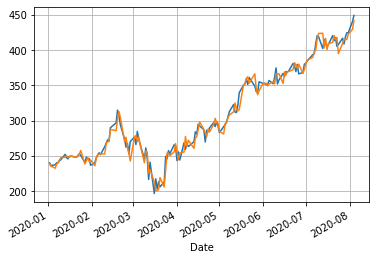

amount of days worth of data:  149
columns available:  ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']


In [ ]:
sample_start = datetime.datetime(2020,1,1)
sample_end = datetime.date.today()
# sample code on how this will all work on a smaller scale
newticker = "nvda"
plt.close()
usertick = data.DataReader(newticker,'yahoo',sample_start,sample_end)
usertick['Close'].plot( grid = True)
usertick['Open'].plot(grid=True)
plt.show()
print("amount of days worth of data: ",len(usertick)) 
print("columns available: ",list(usertick))

In [ ]:
n_steps = batch_steps
n_features = batch.x_train.shape[2]
n_outputs = Predicted_days
l_rate = 0.01
d_rate = 0.05

In [ ]:
earlystop_callback = EarlyStopping(monitor='loss',min_delta=0.0001, patience = 5) 
#stop the learning if we are not getting a change of 0.0001 in each epoch

In [ ]:
# model setup
model = tf.keras.Sequential()
model.add(LSTM(50,activation='relu',input_shape=(n_steps, n_features)))
model.add(Dense(n_outputs))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,451
Trainable params: 11,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(batch.x_train, batch.y_train, validation_data=(batch.x_val,batch.y_val), epochs = 500, verbose= 1, batch_size= 32, shuffle=True, callbacks=[earlystop_callback])

Epoch 1/500
25/25 [==============================] - 1s 22ms/step - loss: 31073.7656 - val_loss: 27411.3066
Epoch 2/500
25/25 [==============================] - 0s 15ms/step - loss: 26468.7168 - val_loss: 23594.4531
Epoch 3/500
25/25 [==============================] - 0s 15ms/step - loss: 25017.0938 - val_loss: 18281.1992
Epoch 4/500
25/25 [==============================] - 0s 15ms/step - loss: 13036.9375 - val_loss: 762.4581
Epoch 5/500
25/25 [==============================] - 0s 15ms/step - loss: 560.0406 - val_loss: 459.8037
Epoch 6/500
25/25 [==============================] - 0s 15ms/step - loss: 479.1681 - val_loss: 924.6797
Epoch 7/500
25/25 [==============================] - 0s 16ms/step - loss: 678.4792 - val_loss: 570.3664
Epoch 8/500
25/25 [==============================] - 0s 16ms/step - loss: 431.9493 - val_loss: 448.6129
Epoch 9/500
25/25 [==============================] - 0s 15ms/step - loss: 487.1347 - val_loss: 386.7904
Epoch 10/500
25/25 [==============================

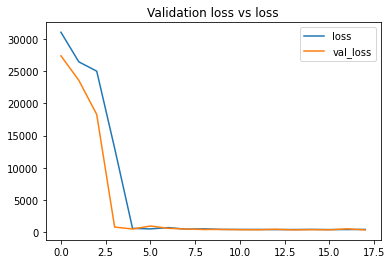

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Validation loss vs loss')
plt.legend(['loss','val_loss'])

In [ ]:
# demonstrate prediction
value_to_check = 6
amount_of_values = 100
x_input = batch.x_test[value_to_check:value_to_check+amount_of_values]
x_input = x_input.reshape((amount_of_values, n_steps, n_features))
prediction = model.predict(x_input, verbose=0)

In [ ]:
accuracy_vals = prediction/batch.y_test[value_to_check:value_to_check+amount_of_values]
accuracy_avg = np.mean(accuracy_vals) 
print("accracy average: ", accuracy_avg)

accracy average:  0.9918185348335427


In [ ]:
true = batch.x_batch[0]
pred = yhat[0]
print (true)
print(pred)

for x in range(Predicted_days):
  confindence = ((pred[x]/true[x]) * 100) - 2
  confindence = confindence/(x+1)
  print("confindence : % 2.2f percent for the next % 2d day(s) with a value of: % 5.2f" %(confindence, (x+1) , pred[x] ))  
  end


[[180.        ]
 [178.44999695]
 [178.61999512]
 [177.8999939 ]
 [180.63000488]
 [181.19999695]
 [180.47000122]
 [180.91999817]
 [181.36999512]
 [179.77999878]
 [181.00999451]
 [181.3500061 ]
 [179.38999939]
 [178.02999878]
 [177.74000549]]
[159.99846 161.5874  161.79463 163.08737 162.47241 162.05716 163.3836 ]
confindence :  86.89 percent for the next  1 day(s) with a value of:  160.00
confindence :  44.28 percent for the next  2 day(s) with a value of:  161.59
confindence :  29.53 percent for the next  3 day(s) with a value of:  161.79
confindence :  22.42 percent for the next  4 day(s) with a value of:  163.09
confindence :  17.59 percent for the next  5 day(s) with a value of:  162.47
confindence :  14.57 percent for the next  6 day(s) with a value of:  162.06
confindence :  12.65 percent for the next  7 day(s) with a value of:  163.38


This is the original testing done for creating a model

In [ ]:
n_steps_test = 6
n_features_test = 1
n_outputs_test = 1

In [ ]:
test_data = np.array([[0,1,2,3,4,5],[1,2,3,4,5,6],[2,3,4,5,6,7],[3,4,5,6,7,8],[4,5,6,7,8,9],[5,6,7,8,9,0],[6,7,8,9,0,1]]) # data which i will be training on
test_y = np.array([6,7,8,9,0,1,2]) # labels to be predicted

In [ ]:
test_data = test_data.reshape(test_data.shape[0],test_data.shape[1],n_features_test)

In [ ]:
test_data.shape

(7, 6, 1)

In [ ]:
# model setup
model = tf.keras.Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps_test, n_features_test)))
model.add(Dense(n_outputs_test))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# training the model
model.fit(test_data, test_y, epochs=200, verbose=0)

In [ ]:
# demonstrate prediction
x_input = np.array([0,1,2,3,4,5])
x_input = x_input.reshape((1, n_steps_test, n_features_test))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[6.0206256]]
